In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

In [17]:
ctx = straxbra.XebraContext()

In [18]:
run = '00201'
peaks_data = ctx.get_array(run, 'peaks')

In [19]:
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
area_per_channel = peaks_data['area_per_channel']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]

In [20]:
def CutCondition(waveform, i):
    
    
    FirstPeak_area = sum(waveform[i][:15]) # range in samples (not ns!)
    Risetime_first_peak = np.argmax(waveform[i][:15])*10
    SecondPeak_area = sum(waveform[i][15:]) # range in samples (not ns!)
    Risetime_second_peak = np.argmax(waveform[i][15:])*10
    
    if  FirstPeak_area > 100 and FirstPeak_area < 600 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
#        print (i , secondS1_area, secondS1_peaktime)
        return(True, Risetime_first_peak, Risetime_second_peak)
    else:
        return(False, 0, 0)
    

In [21]:
def Process(waveform, i):

    CutFlag, Risetime_first_peak, Risetime_second_peak = CutCondition(waveform, i)
    if CutFlag == True:
            
        if integral[i+1] > 300 and width[i+1] >200 and width[i+1] < 2000 and timestamp[i+1] < timestamp[i]+65000: 
            Kr_S2_area.append(integral[i+1])
            Kr_S2_width.append(width[i+1])
            Kr_S2_risetime.append(risetime[i+1])
            Kr_drifttime.append(timestamp[i+1] - timestamp[i])
          
        elif integral[i+2] > 300 and width[i+2] >200 and width[i+2] < 2000 and timestamp[i+2] < timestamp[i]+65000: 
            Kr_S2_area.append(integral[i+2])
            Kr_S2_width.append(width[i+2])
            Kr_S2_risetime.append(risetime[i+2])
            Kr_drifttime.append(timestamp[i+2] - timestamp[i])

        elif integral[i+3] > 300 and width[i+3] >200 and width[i+3] < 2000 and timestamp[i+3] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+3])
            Kr_S2_width.append(width[i+3])
            Kr_S2_risetime.append(risetime[i+3])
            Kr_drifttime.append(timestamp[i+3] - timestamp[i])
  
        elif integral[i+4] > 300 and width[i+4] >200 and width[i+4] < 2000 and timestamp[i+4] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+4])
            Kr_S2_width.append(width[i+4])
            Kr_S2_risetime.append(risetime[i+4])
            Kr_drifttime.append(timestamp[i+4] - timestamp[i])
     
        elif integral[i+5] > 300 and width[i+5] >200 and width[i+5] < 2000 and timestamp[i+5] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+5])
            Kr_S2_width.append(width[i+5])
            Kr_S2_risetime.append(risetime[i+5])
            Kr_drifttime.append(timestamp[i+5] - timestamp[i])

        elif integral[i+6] > 300 and width[i+6] >200 and width[i+6] < 2000 and timestamp[i+6] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+6])
            Kr_S2_width.append(width[i+6])
            Kr_S2_risetime.append(risetime[i+6])
            Kr_drifttime.append(timestamp[i+6] - timestamp[i])
            
        elif integral[i+7] > 300 and width[i+7] >200 and width[i+7] < 2000 and timestamp[i+7] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+7])
            Kr_S2_width.append(width[i+7])
            Kr_S2_risetime.append(risetime[i+7])
            Kr_drifttime.append(timestamp[i+7] - timestamp[i])
            

        elif integral[i+8] > 300 and width[i+8] >200 and width[i+8] < 2000 and timestamp[i+8] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+8])
            Kr_S2_width.append(width[i+8])
            Kr_S2_risetime.append(risetime[i+8])
            Kr_drifttime.append(timestamp[i+8] - timestamp[i])
            
        elif integral[i+9] > 300 and width[i+9] >200 and width[i+9] < 2000 and timestamp[i+9] < timestamp[i]+65000:
            Kr_S2_area.append(integral[i+9])
            Kr_S2_width.append(width[i+9])
            Kr_S2_risetime.append(risetime[i+9])
            Kr_drifttime.append(timestamp[i+9] - timestamp[i])


            


In [22]:
num = len(waveform)

Kr_S2_area = []
Kr_S2_width = []
Kr_S2_risetime = []
Kr_drifttime = []

for i in range(0,num):
    
    Process(waveform,i)

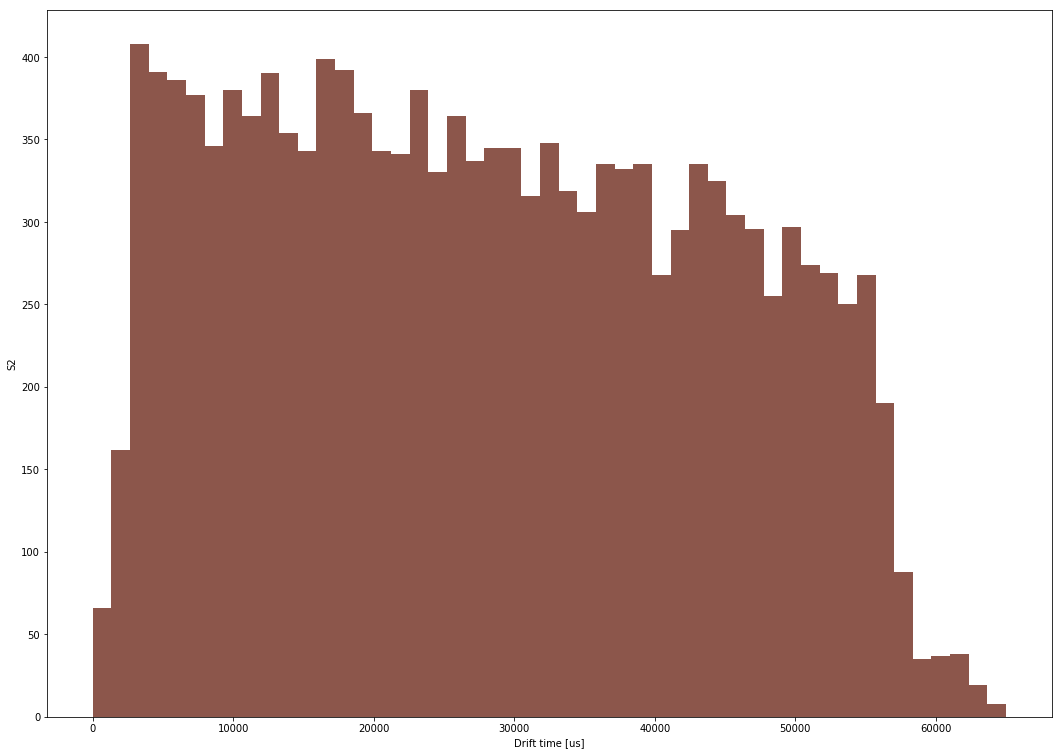

In [26]:
fig, ax = plt.subplots(figsize=(18,13))
bins_x = np.linspace(0,65000,50)
#counts, binEdges = np.histogram(Kr_drifttime, bins=bins_x)
plt.hist(Kr_drifttime, bins=bins_x, color='C5')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()